In [1]:
%matplotlib inline
#import nbs.utils; reload(nbs/utils)
#from utils import *
import matplotlib.pyplot as plt
import math,sys,os
import numpy as np
import numpy.random as rand
from numpy.fft import fft
from matplotlib import rcParams, animation, rc
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3
%precision 4
np.set_printoptions(precision=4, linewidth=100)


from ahkab import new_ac, run, new_op, new_pz, new_tran, time_functions
from ahkab.circuit import Circuit
from ahkab.plotting import plot_results # calls matplotlib for you
from ahkab.netlist_parser import parse_circuit

import ahkab


### Introduction

https://ahkab.readthedocs.io/en/latest/examples/Transient-Example.html

This is an example of transient simulation, featuring the well-known Colpitts oscillator.

![RLC Filter](./pictures/colpitts.png)

Bias:

Vdd=2.5V, Vbias=2V

Passives:

L1=5nH, R0=3.14kΩ (QL=33 @ 3 GHz)

C1=C2=1.012pF(resulting in n=C1/(C1+C2)=0.5)

C2 has a Q greater than 10 for every Ib less than (w0C2)2/(2K102) = 4.8 mA.

Under such condition, the minimum transconductance required for oscillation can be calculated considering the MOS transistor an ideal voltage probe. The presence of the MOS has to be taken into account when evaluating the overall Q of the tank.

Under such hypothesis: gm,min=1/(n(1−n)R0), Ib,min=1.27 mA. In the following we use Ib = 1.3mA.

### Define schematic

In [2]:
osc = Circuit('MOS COLPITTS OSCILLATOR')

# models need to be defined before the devices that use them
osc.add_model('ekv', 'nmos', dict(TYPE='n', VTO=.4, KP=10e-6))

osc.add_vsource('vdd', n1='dd', n2=osc.gnd, dc_value=3.3)

# Ql = 33 at 3GHz
osc.add_inductor('l1', n1='dd', n2='nd', value=5e-9, ic=-1e-9)
osc.add_resistor('r0', n1='nd', n2='dd', value=3.5e3)

# n = 0.5, f0 = 3GHz
osc.add_capacitor('c1', n1='nd', n2='ns', value=1.12e-12)
osc.add_capacitor('c2', n1='ns', n2=osc.gnd, value=1.12e-12)

osc.add_mos('m1', nd='nd1', ng='bias', ns='ns', nb='ns',
            model_label='nmos', w=600e-6, l=100e-9)
# voltage source as a current probe
osc.add_vsource('vtest', n1='nd', n2='nd1', dc_value=0)

# Bias
osc.add_vsource('vbias', n1='bias', n2=osc.gnd, dc_value=2.)
osc.add_isource('ib', n1='ns', n2=osc.gnd, dc_value=1.3e-3)


### calculate an Operating Point (OP) to initialize the transient analysis

In [3]:
op = ahkab.new_op()
res = run(osc, op)
print(res['op'])

OP simulation results for 'MOS COLPITTS OSCILLATOR'.
Run on 2017-04-20 16:13:21, data file /tmp/tmpzry7hf3f.op.
Variable    Units       Value         Error    %
----------  -------  --------  ------------  ---
VDD         V         2.97      0              0
VND         V         2.97      0              0
VNS         V         1.38523   9.57578e-10    0
VND1        V         2.97     -9.57578e-10    0
VBIAS       V         1.8       0              0
I(VDD)      A        -0.00117   0              0
I(L1)       A         0.00117   0              0
I(VTEST)    A         0.00117   0              0
I(VBIAS)    A         0         0              0


## transient simulation

In [4]:
# Setup and run a transient analysis with the modified x0 as start point
tran = ahkab.new_tran(tstart=0., tstop=20e-9, tstep=.05e-9, method='trap',
                      x0=None)
res.update( run(osc, tran) )

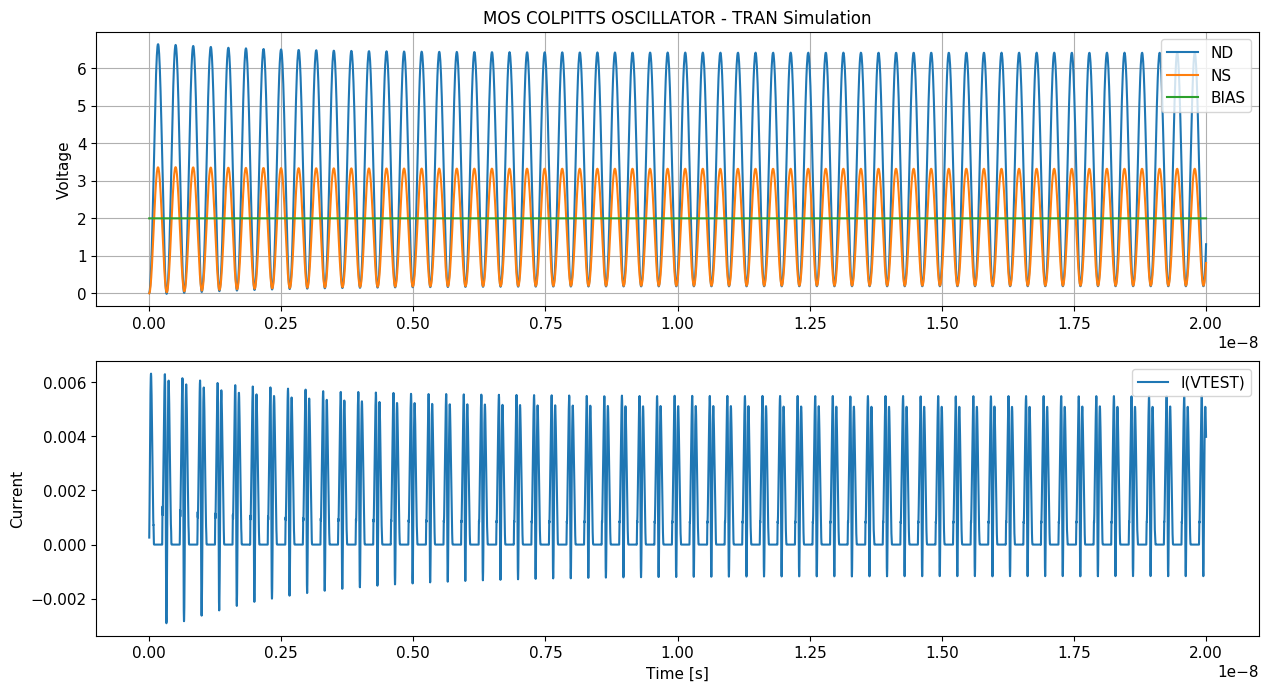

In [5]:
xoff = res['tran'].get_x()[res['tran'].get_x() >= 1.9e-8 ].size

t = res['tran'].get_x()

plt.figure(figsize=[15,8],dpi=100)
plt.subplot(211)
plt.title(osc.title + " - TRAN Simulation")
plt.plot(t, res['tran']['vnd'], label='ND')
plt.plot(t, res['tran']['vns'], label='NS')
plt.plot(t, res['tran']['vbias'], label='BIAS')
plt.legend()
plt.grid(True)
plt.ylabel('Voltage')
plt.subplot(212)
plt.plot(t, res['tran']['i(vtest)'], label='I(VTEST)')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Current')


### modify the OP to give the circuit a little kick to start the oscillation and run transient simulation

In [6]:
x0 = res['op'].asarray()
#x0[2] += -1e-9
x0[0] = 0
x0[2] = 0

# Setup and run a transient analysis with the modified x0 as start point
tran = ahkab.new_tran(tstart=0., tstop=20e-9, tstep=.05e-9, method='trap',
                      x0=x0)
res.update( run(osc, tran) )

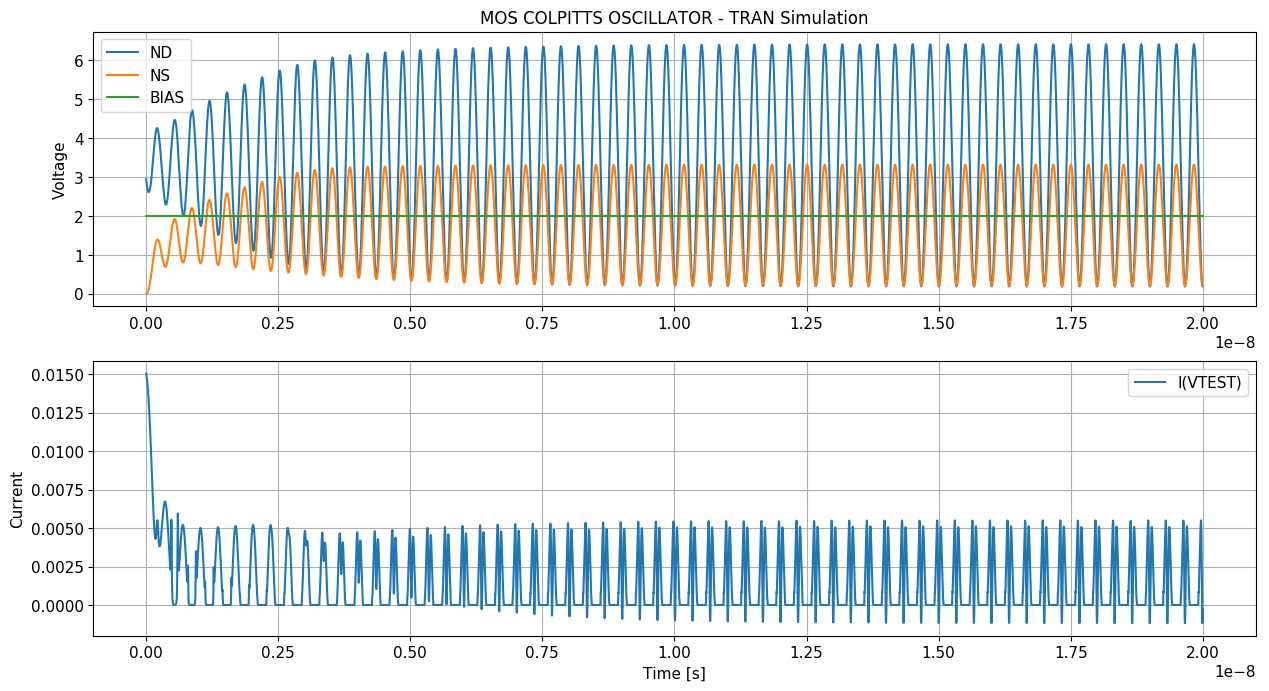

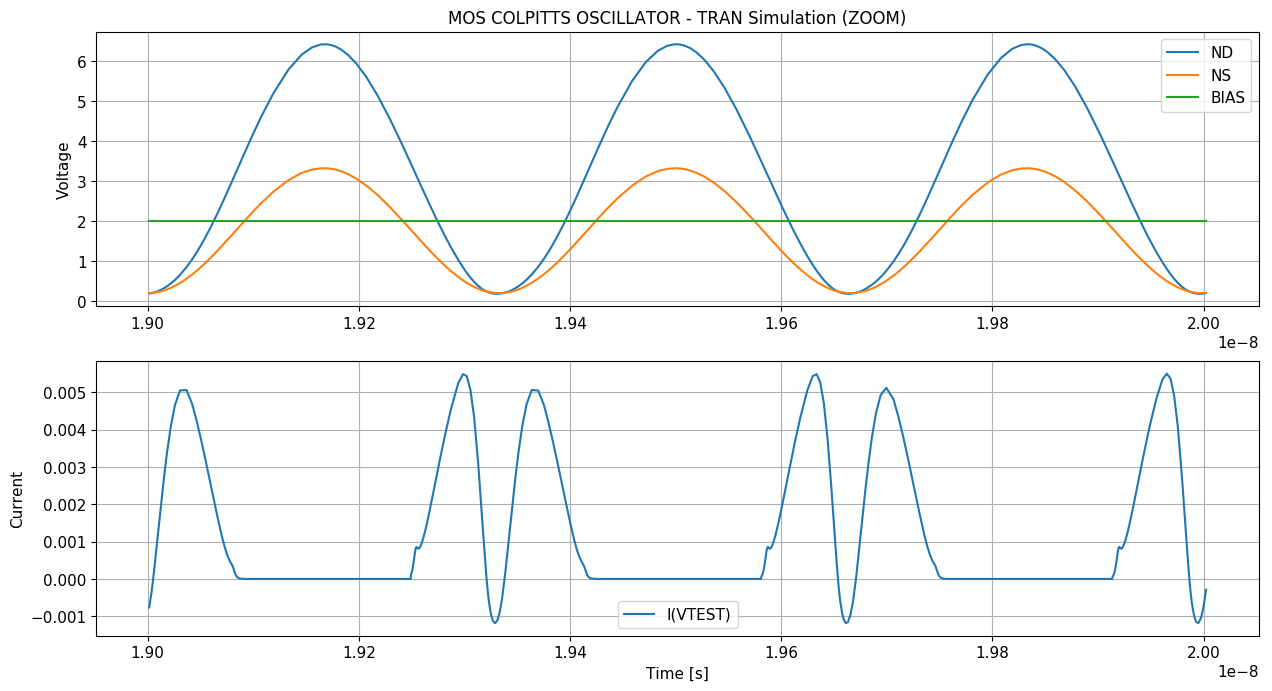

In [7]:
xoff = res['tran'].get_x()[res['tran'].get_x() >= 1.9e-8 ].size

t = res['tran'].get_x()


plt.figure(figsize=[15,8],dpi=100)
plt.subplot(211)
plt.title(osc.title + " - TRAN Simulation")
plt.plot(t, res['tran']['vnd'], label='ND')
plt.plot(t, res['tran']['vns'], label='NS')
plt.plot(t, res['tran']['vbias'], label='BIAS')
plt.legend()
plt.grid(True)
plt.ylabel('Voltage')
plt.subplot(212)
plt.plot(t, res['tran']['i(vtest)'], label='I(VTEST)')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Current')
plt.grid(True)

t = res['tran'].get_x()[-xoff:]
plt.figure(figsize=[15,8],dpi=100)
plt.subplot(211)
plt.title(osc.title + " - TRAN Simulation (ZOOM)")
plt.plot(t, res['tran']['vnd'][-xoff:], label='ND')
plt.plot(t, res['tran']['vns'][-xoff:], label='NS')
plt.plot(t, res['tran']['vbias'][-xoff:], label='BIAS')
plt.legend()
plt.ylabel('Voltage')
plt.grid(True)
plt.subplot(212)
plt.plot(t, res['tran']['i(vtest)'][-xoff:], label='I(VTEST)')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Current')
plt.grid(True)

## Fast Fourier Transformation

#Frequencies =  5556


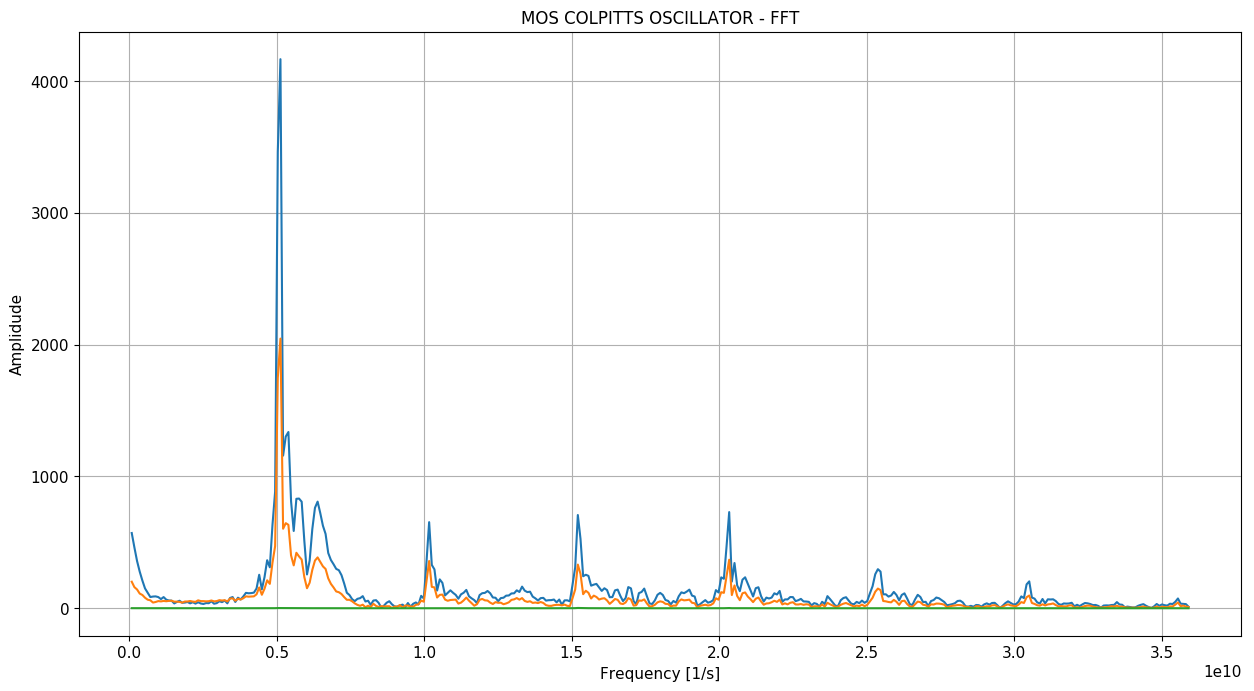

In [9]:
f_nd=fft(res['tran']['vnd'])
f_ns=fft(res['tran']['vns'])
f_it=fft(res['tran']['i(vtest)'])
f = np.fft.fftfreq(f_nd.size, res['tran'].get_x()[1]-res['tran'].get_x()[0])
print("#Frequencies = " , f.size)

plt.figure(figsize=[15,8],dpi=100)
plt.title(osc.title + " - FFT")
plt.plot(f[1:400],np.abs(f_nd[1:400]),label="vnd")
plt.plot(f[1:400],np.abs(f_ns[1:400]),label="vns")
plt.plot(f[1:400],np.abs(f_it[1:400]),label="i(vtest)")
plt.grid(True)
plt.xlabel('Frequency [1/s]')
plt.ylabel('Amplidude')

## Normalice FFT

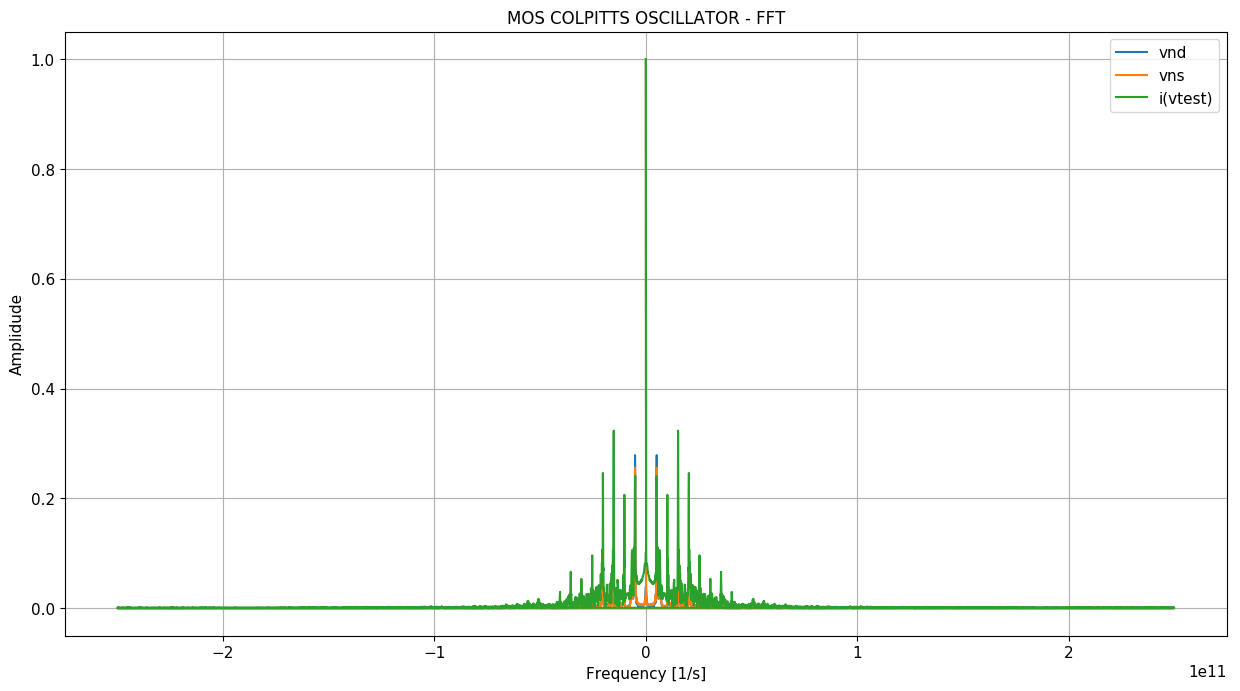

In [10]:
fn_nd = np.abs(f_nd)/np.abs(f_nd).max()
fn_ns = np.abs(f_ns)/np.abs(f_ns).max()
fn_it = np.abs(f_it)/np.abs(f_it).max()

plt.figure(figsize=[15,8],dpi=100)
plt.title(osc.title + " - FFT")
plt.plot(f,fn_nd,label="vnd")
plt.plot(f,fn_ns,label="vns")
plt.plot(f,fn_it,label="i(vtest)")
plt.grid(True)
plt.legend()
plt.xlabel('Frequency [1/s]')
plt.ylabel('Amplidude')

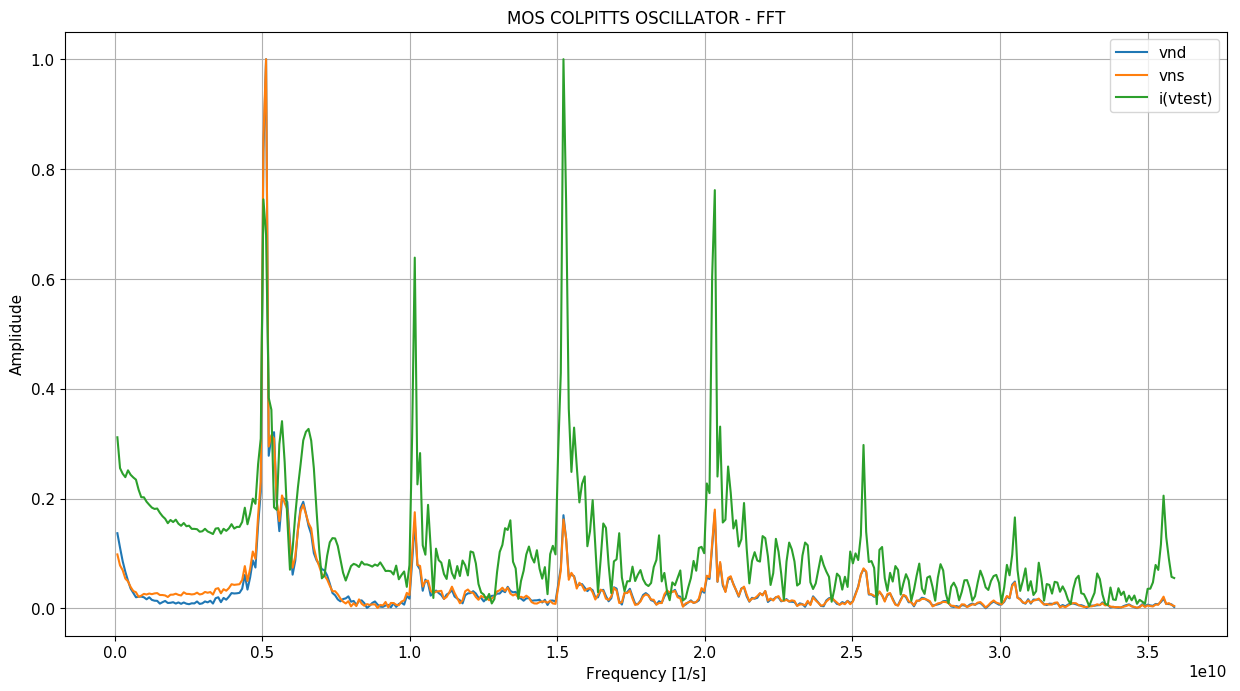

In [11]:
fn_nd = np.abs(f_nd[1:400])/np.abs(f_nd[1:400]).max()
fn_ns = np.abs(f_ns[1:400])/np.abs(f_ns[1:400]).max()
fn_it = np.abs(f_it[1:400])/np.abs(f_it[1:400]).max()

plt.figure(figsize=[15,8],dpi=100)
plt.title(osc.title + " - FFT")
plt.plot(f[1:400],fn_nd,label="vnd")
plt.plot(f[1:400],fn_ns,label="vns")
plt.plot(f[1:400],fn_it,label="i(vtest)")
plt.grid(True)
plt.legend()
plt.xlabel('Frequency [1/s]')
plt.ylabel('Amplidude')

In [13]:
ind = np.abs(f_nd[0:2000]).argsort()[-10:][::-1]

print(ind)
print(f[ind])
print(f_nd[ind])

[ 0 57 56 60 59 58 55 64 63 61]
[  0.0000e+00   5.1291e+09   5.0391e+09   5.3990e+09   5.3090e+09   5.2191e+09   4.9491e+09
   5.7590e+09   5.6690e+09   5.4890e+09]
[ 14934.6283   +0.j        882.7116-4070.3357j  -3310.3502+1010.5416j    627.7421-1180.5019j
   1221.0369 +453.0434j  -1023.3048 +542.0477j   -346.7137 +814.481j     739.8927 -380.8901j
    729.4542 +396.7218j   -693.5143 -422.0923j]
